<a href="https://colab.research.google.com/github/malhotrakavyansh/DevComm-JC/blob/main/task_1/task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kavyanshmalhotra","key":"944124b4750dde401bb0fc6251f8c30c"}'}

In [ ]:
! mkdir ~/.kaggle


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                     title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
urvishahir/electric-vehicle-specifications-dataset-2025                 Electric Vehicle Specs Dataset (2025)                    16631  2025-06-20 07:14:56.777000           7046        176  1.0              
divyaraj2006/social-media-engagement                                    social media engagement                                   2142  2025-07-02 15:34:21.323000           3246         67  1.0              
sahilislam007/college-student-placement-factors-dataset                 College Student Placement Factors Dataset               110450  2025-07-02 08:33:50.547000      

In [ ]:
!kaggle competitions download -c jc-dev-comm-recruitment-task --force

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 435MB/s]


In [ ]:
!unzip jc-dev-comm-recruitment-task.zip

Archive:  jc-dev-comm-recruitment-task.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


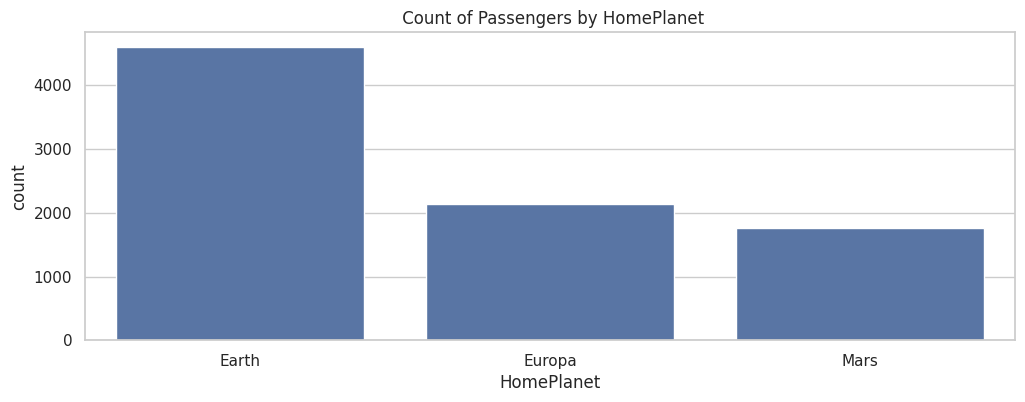

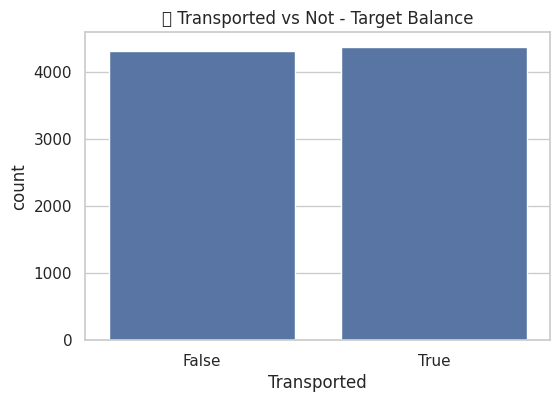

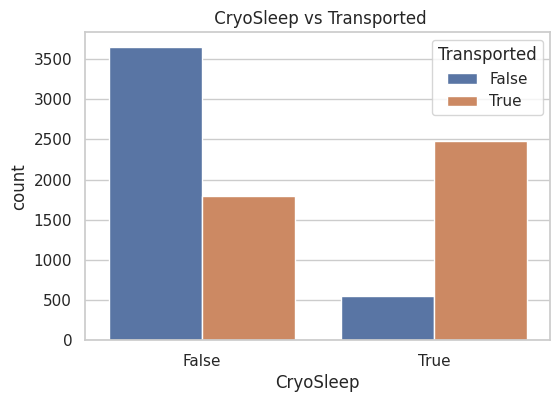

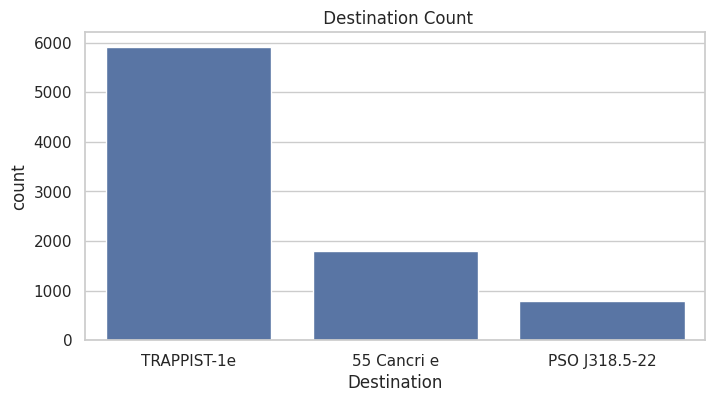

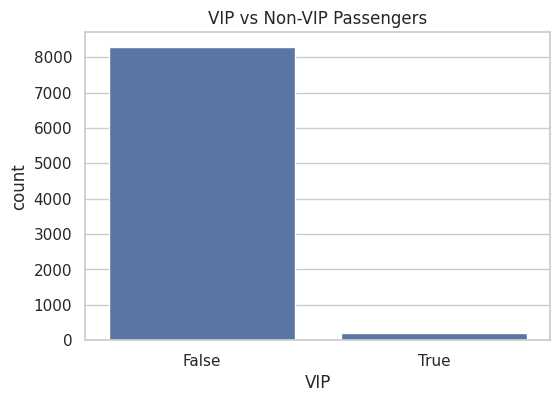

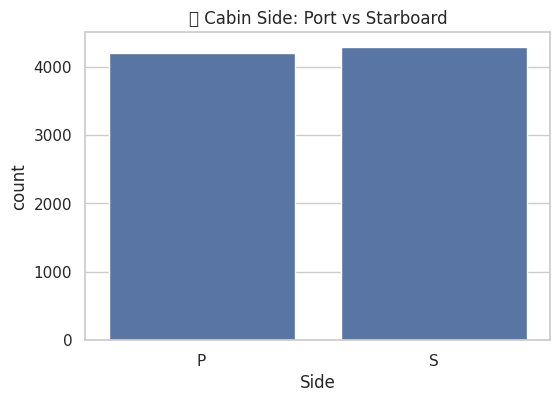

 Validation Accuracy: 0.7861
📦 Submission file created: submission.csv


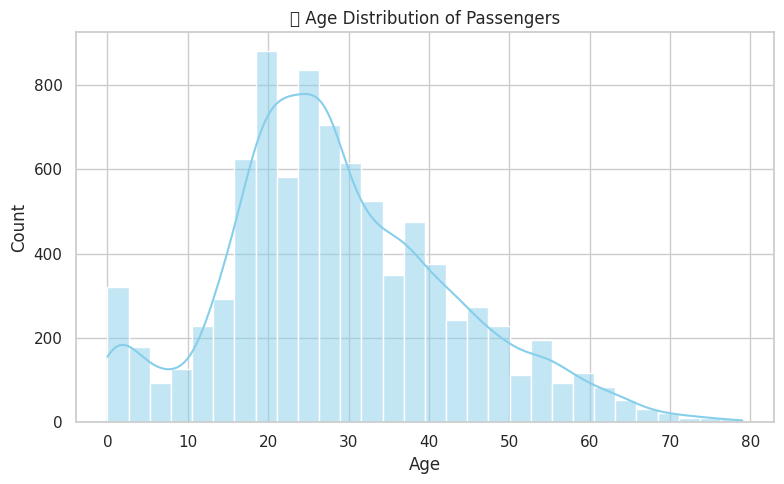

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


sns.set(style="whitegrid")


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


plt.figure(figsize=(12, 4))
sns.countplot(data=train, x="HomePlanet", order=train["HomePlanet"].value_counts().index)
plt.title(" Count of Passengers by HomePlanet")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=train, x="Transported")
plt.title("🌍 Transported vs Not - Target Balance")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=train, x="CryoSleep", hue="Transported")
plt.title(" CryoSleep vs Transported")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=train, x="Destination", order=train["Destination"].value_counts().index)
plt.title(" Destination Count")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=train, x="VIP")
plt.title("VIP vs Non-VIP Passengers")
plt.show()


train["Cabin"] = train["Cabin"].fillna("Unknown")
train[["Deck", "Num", "Side"]] = train["Cabin"].str.split("/", expand=True)

plt.figure(figsize=(6, 4))
sns.countplot(data=train, x="Side")
plt.title("🛏️ Cabin Side: Port vs Starboard")
plt.show()


fill_values = {
    "HomePlanet": "Earth",
    "CryoSleep": False,
    "Destination": "TRAPPIST-1e",
    "Age": train["Age"].median(),
    "VIP": False,
    "RoomService": 0,
    "FoodCourt": 0,
    "ShoppingMall": 0,
    "Spa": 0,
    "VRDeck": 0
}
train.fillna(fill_values, inplace=True)
test.fillna(fill_values, inplace=True)


def split_cabin(df):
    df["Cabin"] = df["Cabin"].fillna("Unknown")
    df[["Deck", "Num", "Side"]] = df["Cabin"].str.split("/", expand=True)
    df.drop("Cabin", axis=1, inplace=True)
    return df

train = split_cabin(train)
test = split_cabin(test)


y = train["Transported"]
train = train.drop("Transported", axis=1)


categorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Deck", "Side"]
train_encoded = pd.get_dummies(train, columns=categorical_cols)
test_encoded = pd.get_dummies(test, columns=categorical_cols)

train_encoded, test_encoded = train_encoded.align(test_encoded, join='outer', axis=1, fill_value=0)


drop_cols = ["Name", "PassengerId", "Num"]
X = train_encoded.drop(columns=[col for col in drop_cols if col in train_encoded.columns])
X_test = test_encoded.drop(columns=[col for col in drop_cols if col in test_encoded.columns])


missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0

extra_cols = set(X_test.columns) - set(X.columns)
for col in extra_cols:
    X[col] = 0

X_test = X_test[X.columns]


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


val_preds = model.predict(X_valid)
accuracy = accuracy_score(y_valid, val_preds)
print(f" Validation Accuracy: {accuracy:.4f}")


model.fit(X, y)
final_predictions = model.predict(X_test)


submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Transported": final_predictions
})
submission.to_csv("submission.csv", index=False)
print("📦 Submission file created: submission.csv")


plt.figure(figsize=(8, 5))
sns.histplot(data=train, x="Age", bins=30, kde=True, color="skyblue")
plt.title("📊 Age Distribution of Passengers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
